In [589]:
## Handle necessary imports
# Pandas, numpy, matplotlib, seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bigram, Trigram combinations
import itertools
from itertools import combinations

# Biopython
from Bio import SeqIO, SeqUtils
from Bio.SeqUtils import ProtParamData
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Classsifiers
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [7]:
#Load fasta sequence data
cyto = 'data/cyto.fasta.txt'
mito = 'data/mito.fasta.txt'
nucleus = 'data/nucleus.fasta.txt'
secreted = 'data/secreted.fasta.txt'
blind = 'data/blind.fasta.txt'

In [8]:
#Load 'cyto' data into dataframe and add label
with open(cyto) as file:  
    identifiers = []
    cytosequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        identifiers.append(seq_record.id)
        cytosequences.append(seq_record.seq)

cyto_df = pd.DataFrame.from_records(cytosequences)
cyto_df['label'] = 'cyto'

#Replace None entries with NaN: useful for features later
cyto_df.fillna(value=np.nan, inplace=True)

In [9]:
#Load 'mito' data into dataframe and add label
with open(mito) as file:  
    identifiers = []
    mitosequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        identifiers.append(seq_record.id)
        mitosequences.append(seq_record.seq)

mito_df = pd.DataFrame.from_records(mitosequences)
mito_df['label'] = 'mito'

#Replace None entries with NaN: useful for features later
mito_df.fillna(value=np.nan, inplace=True)

In [10]:
#Load 'nucleus' data into dataframe and add label
with open(nucleus) as file:  
    identifiers = []
    nucsequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        identifiers.append(seq_record.id)
        nucsequences.append(seq_record.seq)

nucleus_df = pd.DataFrame.from_records(nucsequences)
nucleus_df['label'] = 'nucleus'

#Replace None entries with NaN: useful for features later
nucleus_df.fillna(value=np.nan, inplace=True)

In [11]:
#Load 'secreted' data into dataframe and add label
with open(secreted) as file:  
    identifiers = []
    secsequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        identifiers.append(seq_record.id)
        secsequences.append(seq_record.seq)

secreted_df = pd.DataFrame.from_records(secsequences)
secreted_df['label'] = 'secreted'

#Replace None entries with NaN: useful for features later
secreted_df.fillna(value=np.nan, inplace=True)

In [12]:
#Load 'blind' data into dataframe and add label
with open(blind) as file:  
    blindidentifiers = []
    blindsequences = []
    for seq_record in SeqIO.parse(file, 'fasta'):  
        blindidentifiers.append(seq_record.id)
        blindsequences.append(seq_record.seq)

blind_df = pd.DataFrame.from_records(blindsequences)
blind_df['label'] = 'blind'

#Replace None entries with NaN: useful for features later
blind_df.fillna(value=np.nan, inplace=True)

In [303]:
# All sequence data
sequences = cytosequences+mitosequences+nucsequences+secsequences+blindsequences

In [304]:
#Concatanate the dataframes into one with all the sequence data
full_data=pd.concat([cyto_df,mito_df,nucleus_df,secreted_df,blind_df],0,ignore_index=True)

In [305]:
#Reindex the label column as the last column
cols = full_data.columns.tolist()
cols.insert(np.shape(full_data)[1], cols.pop(cols.index('label')))
full_data = full_data.reindex(columns= cols)
full_data.head()

,0,1,2,3,4,5,6,7,8,9,...,13091,13092,13093,13094,13095,13096,13097,13098,13099,label
0,M,G,Q,Q,V,G,R,V,G,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto
1,M,A,L,E,P,I,D,Y,T,T,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto
2,M,N,Q,I,E,P,G,V,Q,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto
3,M,S,E,E,P,T,P,V,S,G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto
4,M,G,D,W,M,T,V,T,D,P,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cyto


In [306]:
# Split labels column from data
labels = full_data.pop('label')

In [307]:
# Define the train test split point
train_idx = 9222
train = full_data[:train_idx]
test = full_data[train_idx:]

In [308]:
# Feature engineering starts here 
# i.e. find relevant features for the sequence data

# 1. Sequence length
sequence_length = pd.DataFrame(full_data.count(axis=1),columns=['seq_len'])
sequence_length = sequence_length.astype(float)

In [309]:
# 2. Global amino acid count i.e. no of amino acid per sequence
global_count = full_data.T

d = {}
for i in range(len(full_data)):
    series_global = global_count.groupby(i).size()
    d[str(i)]=pd.DataFrame({i:series_global.values},index = series_global.index+' global')

global_counts_feats = pd.concat([d[str(i)] for i in range(len(d))],axis=1)
global_counts_feats = global_counts_feats.fillna(0)
global_counts_feats = global_counts_feats.T

In [311]:
# 3. Bigram amino counts i.e (AB, AC, AE etc)
aminos = pd.DataFrame(series_global.index)
aminos.columns = ['amino']

bigrams = pd.DataFrame(list(combinations(aminos.amino, 2)))
bigrams = bigrams.apply(lambda x: ''.join(x), axis=1)
bicnt=[]

for seq in sequences:
    for bi in bigrams:
        bicnt.append(seq.count(bi))
        
bigramcounts = [bicnt[i:i+190] for i  in range(0, len(bicnt), 190)]

bigram_count_df = pd.DataFrame(bigramcounts)
bigram_count_df.columns = bigrams

,AC,AD,AE,AF,AG,AH,AI,AK,AL,AM,...,ST,SV,SW,SY,TV,TW,TY,VW,VY,WY
0,1,9,8,3,11,1,3,6,6,2,...,7,2,1,0,4,0,2,2,6,1
1,0,1,10,0,2,0,0,4,1,0,...,2,0,0,1,0,1,0,0,0,0
2,1,2,10,4,3,2,5,3,8,3,...,2,2,1,1,2,1,1,0,1,0
3,1,1,12,5,4,2,5,6,6,0,...,2,7,0,1,0,1,2,1,1,0
4,0,1,2,3,1,0,1,0,0,1,...,2,2,2,2,3,0,0,0,0,0
5,0,0,3,2,1,0,1,4,2,1,...,0,0,0,0,0,1,0,0,1,0
6,0,2,5,1,2,1,3,5,4,1,...,3,1,0,2,2,0,1,0,0,0
7,2,0,4,1,3,1,2,2,4,0,...,0,6,1,5,6,0,1,1,0,1
8,0,1,0,2,1,1,1,2,0,1,...,0,2,0,0,4,0,1,0,1,0
9,0,2,0,1,0,0,0,3,2,1,...,2,4,1,0,0,0,0,0,0,0


In [290]:
# 4. Trigram amino counts i.e (ABC, ACE etc)
aminos = pd.DataFrame(series_global.index)
aminos.columns = ['amino']

from itertools import combinations
sequences = cytosequences+mitosequences+nucsequences+secsequences+blindsequences
trigrams = pd.DataFrame(list(combinations(aminos.amino, 3)))
trigrams = trigrams.apply(lambda x: ''.join(x), axis=1)
tricnt=[]

for seq in sequences:
    for tri in trigrams:
        tricnt.append(seq.count(tri))
trigramcounts = [tricnt[i:i+969] for i  in range(0, len(tricnt), 969)]

trigram_count_df = pd.DataFrame(trigramcounts)
trigram_count_df.columns = trigrams

,ACE,ACF,ACG,ACH,ACI,ACK,ACL,ACM,ACN,ACP,...,STV,STW,STY,SVW,SVY,SWY,TVW,TVY,TWY,VWY
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [525]:
# Find the best split for local amino count
aminoFirstCount=[]
aminoLastCount=[]
cnt = np.arange(10,60,10)

for j in cnt:
    for i in range(len(sequences)):
            X=ProteinAnalysis(str(sequences[i][j:]))
            aminoFirstCount.append(X.count_amino_acids())
for j in cnt:
    for i in range(len(sequences)):
            X=ProteinAnalysis(str(sequences[i][:j]))
            aminoLastCount.append(X.count_amino_acids())

aminofirstchunk = [aminoFirstCount[i:i+len(sequences)] for i  in range(0, len(aminoFirstCount), len(sequences))]
aminofirst10 = pd.DataFrame(aminofirstchunk[0])
aminofirst10.columns = [str(cols)+'_first' for cols in aminofirst10.columns]
aminofirst20 = pd.DataFrame(aminofirstchunk[1])
aminofirst20.columns = [str(cols)+'_first' for cols in aminofirst20.columns]
aminofirst30 = pd.DataFrame(aminofirstchunk[2])
aminofirst30.columns = [str(cols)+'_first' for cols in aminofirst30.columns]
aminofirst40 = pd.DataFrame(aminofirstchunk[3])
aminofirst40.columns = [str(cols)+'_first' for cols in aminofirst40.columns]
aminofirst50 = pd.DataFrame(aminofirstchunk[4])
aminofirst50.columns = [str(cols)+'_first' for cols in aminofirst50.columns]

aminolastchunk = [aminoLastCount[i:i+len(sequences)] for i  in range(0, len(aminoLastCount), len(sequences))]
aminolast10 = pd.DataFrame(aminolastchunk[0])
aminolast10.columns = [str(cols)+'_last' for cols in aminolast10.columns]
aminolast20 = pd.DataFrame(aminolastchunk[1])
aminolast20.columns = [str(cols)+'_last' for cols in aminolast20.columns]
aminolast30 = pd.DataFrame(aminolastchunk[2])
aminolast30.columns = [str(cols)+'_last' for cols in aminolast30.columns]
aminolast40 = pd.DataFrame(aminolastchunk[3])
aminolast40.columns = [str(cols)+'_last' for cols in aminolast40.columns]
aminolast50 = pd.DataFrame(aminolastchunk[4])
aminolast50.columns = [str(cols)+'_last' for cols in aminolast50.columns]

acc=[]
feats=[]

for feat_first, featfirst_name in zip([aminofirst10, aminofirst20, aminofirst30, aminofirst40, aminofirst50], 
                      ['First 10%', 'First 20%', 'First 30%','First 40%', 'First 50%']):    
    for feat_last, featlast_name in zip([aminolast10, aminolast20, aminolast30, aminolast40, aminolast50], 
                      ['Last 10%', 'Last 20%', 'Last 30%','Last 40%', 'Last 50%']):   
        features_df = pd.concat([feat_first, feat_last],1)
        labels = labels[:train_idx]
        test_df = features_df[train_idx:]
        features_df = features_df[:train_idx]
        le = preprocessing.LabelEncoder()
        le.fit(labels.values)
        labels_enc=le.transform(labels)
        labels_df = pd.DataFrame(labels_enc,columns=['labels'])
        X_train, X_test, y_train, y_test = train_test_split(features_df, labels_enc, random_state=0, test_size=0.3)
        lr = LogisticRegression()
        y_pred_lr = lr.fit(X_train, y_train).predict(X_test)
        acc.append(metrics.accuracy_score(y_test, y_pred_lr))
        feats.append([featfirst_name, featlast_name])
results = pd.DataFrame()
results['Accuracy'] = acc
results['Combinations'] = feats
        

results = results.sort_values(by='Accuracy', ascending=False)
results[0]

,Accuracy,Combinations
8,0.631731,"[First 20%, Last 40%]"
9,0.629924,"[First 20%, Last 50%]"
23,0.629201,"[First 50%, Last 40%]"
24,0.628840,"[First 50%, Last 50%]"
6,0.628840,"[First 20%, Last 20%]"
7,0.628840,"[First 20%, Last 30%]"
3,0.628478,"[First 10%, Last 40%]"
4,0.628478,"[First 10%, Last 50%]"
14,0.628478,"[First 30%, Last 50%]"
1,0.628117,"[First 10%, Last 20%]"


In [ ]:
# 6. First 50 amino acid count 
local_count_first50 = global_count.drop(global_count.index[50:])

d = {}
for i in range(len(full_data)):
    series_global = local_count_first50.groupby(i).size()
    d[str(i)]=pd.DataFrame({i:series_global.values},index = series_global.index+' first50')

first50_counts_feats = pd.concat([d[str(i)] for i in range(len(d))],axis=1)
first50_counts_feats = first50_counts_feats.fillna(0)
first50_counts_feats = first50_counts_feats.T


In [20]:
# 7. Last 50 amino acid count 
local_count_last50 = global_count.drop(global_count.index[:50])

d = {}
for i in range(len(full_data)):
    series_global = local_count_last50.groupby(i).size()
    d[str(i)]=pd.DataFrame({i:series_global.values},index = series_global.index+' last50')

last50_counts_feats = pd.concat([d[str(i)] for i in range(len(d))],axis=1)
last50_counts_feats = last50_counts_feats.fillna(0)
last50_counts_feats = last50_counts_feats.T

In [22]:
## Biopython Protein Analysis Features
# 8. Isoelectric Point
# 9. Aromaticity
# 10. Secondary Structure Fraction
# 11. Gravy
# 12. Instability Index
# 13. Flexibility
# 14. Amino Percent
# 15. Molecular Weight
# 16. Protein Scale ~ Hydrophobicity
# 17. Protein Scale ~ Hydrophilicity
# 18. Protein Scale ~ Surface accessibility 

sequences = cytosequences+mitosequences+nucsequences+secsequences+blindsequences
isoelectricPt=[]
aromaticity=[]
aminoPercent=[]
secstruct=[]
hydrophob=[]
hydrophil=[]
surface=[]
gravy=[]
molweight=[]
instidx=[]
flex=[]

for seq in sequences:
        X=ProteinAnalysis(str(seq))
        isoelectricPt.append(X.isoelectric_point())
        aromaticity.append(X.aromaticity())  
        aminoPercent.append(X.get_amino_acids_percent())
        secstruct.append(X.secondary_structure_fraction())

# These features throw Key & Value Errors due to non standard amino acids
# (i.e. out of the 20 standard ones) e.g. X, U etc
        try:
            gravy.append(X.gravy())
            molweight.append(X.molecular_weight())
            instidx.append(X.instability_index())
            flex.append(X.flexibility())
            hydrophob.append(X.protein_scale(ProtParamData.kd, 9, 0.4))
            hydrophil.append(X.protein_scale(ProtParamData.hw, 9, 0.4))
            surface.append(X.protein_scale(ProtParamData.em, 9, 0.4))

        except (KeyError,ValueError):
            gravy.append(0)
            molweight.append(0)
            instidx.append(0)
            flex.append([0,0])
            hydrophob.append([0,0])
            hydrophil.append([0,0])
            surface.append([0,0])

isoelectricPt_df = pd.DataFrame(isoelectricPt,columns=['isoelectricPt'])
aromaticity_df = pd.DataFrame(aromaticity,columns=['aromaticity'])
aminoPercent_df = pd.DataFrame()
aminoPercent_df = aminoPercent_df.from_dict(aminoPercent)
aminoPercent_df.columns = [str(col) + '%' for col in aminoPercent_df.columns]
secstruct_df = pd.DataFrame(secstruct,columns=['helix','turn','sheet'])
instidx_df = pd.DataFrame(instidx, columns=['instabilityIdx'])
gravy_df = pd.DataFrame(gravy, columns=['gravy'])
molWeight_df = pd.DataFrame(molweight, columns=['molWeight'])
flex_df = pd.DataFrame(pd.DataFrame(flex).mean(axis=1), columns=['flexibility'])
hydrophob_df = pd.DataFrame(pd.DataFrame(hydrophob).mean(axis=1), columns=['hydrophobicity'])
hydrophil_df = pd.DataFrame(pd.DataFrame(hydrophil).mean(axis=1), columns=['hydrophilicity'])
surface_df = pd.DataFrame(pd.DataFrame(surface).mean(axis=1), columns=['surface_accesibility'])

In [549]:
# Final feature dataframe to be used for model
features_df = pd.concat([sequence_length,secstruct_df, flex_df,isoelectricPt_df,aromaticity_df,instidx_df,
                         gravy_df,aminoPercent_df,hydrophob_df, hydrophil_df, surface_df, molWeight_df,
                         global_counts_feats,aminofirst20,aminolast40], 1)

features_df.head(10)

,seq_len,helix,turn,sheet,flexibility,isoelectricPt,aromaticity,instabilityIdx,gravy,A%,...,M_last,N_last,P_last,Q_last,R_last,S_last,T_last,V_last,W_last,Y_last
0,1182.0,0.241963,0.296108,0.252961,1.008064,7.965393,0.067682,52.288164,-0.509983,0.082064,...,1,0,5,5,8,3,0,2,0,0
1,592.0,0.197635,0.285473,0.282095,1.025372,4.589172,0.060811,61.758615,-1.042061,0.094595,...,1,1,3,0,2,3,4,1,1,2
2,894.0,0.282998,0.164430,0.313199,1.003840,5.307678,0.078300,43.180884,-0.597315,0.083893,...,2,2,2,5,1,0,0,2,2,4
3,861.0,0.298490,0.188153,0.295006,1.007373,5.001526,0.073171,41.535075,-0.466783,0.078978,...,1,3,2,2,1,3,4,1,2,0
4,614.0,0.250814,0.214984,0.268730,1.012336,6.029358,0.061889,52.350000,-0.882410,0.032573,...,3,0,2,3,0,9,5,2,1,2
5,309.0,0.304207,0.216828,0.258900,1.002160,6.351501,0.119741,47.342104,-0.429773,0.067961,...,2,0,3,0,4,4,1,4,3,0
6,730.0,0.241096,0.257534,0.261644,1.013983,8.869812,0.047945,56.928630,-0.696027,0.065753,...,1,1,0,1,3,2,3,3,0,1
7,867.0,0.329873,0.235294,0.206459,0.998454,9.027649,0.089965,41.530242,-0.301384,0.041522,...,2,6,0,0,1,8,0,0,0,0
8,176.0,0.318182,0.238636,0.210227,1.001858,5.006897,0.096591,34.325568,-0.048295,0.090909,...,2,1,2,3,0,6,1,2,1,2
9,338.0,0.281065,0.215976,0.263314,1.007604,5.406067,0.094675,23.513343,-0.549704,0.059172,...,1,4,1,0,3,2,3,2,5,0


In [550]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
features_df_scaled = features_df.copy()
scaler = StandardScaler().fit(features_df_scaled)
features_df_scaled = scaler.transform(features_df_scaled)
features_df_scaled = features_df_scaled

In [551]:
# Split out the test set
labels = labels[:train_idx]
test_df = features_df_scaled[train_idx:]
features_df_scaled = features_df_scaled[:train_idx]

In [552]:
# Encoding the 4 class labels
le = preprocessing.LabelEncoder()
le.fit(labels.values)

labels_enc=le.transform(labels)
labels_df = pd.DataFrame(labels_enc,columns=['labels'])

In [553]:
# Split the training data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(features_df_scaled, labels_enc, random_state=0, test_size=0.3)

In [554]:
# Basic Logistic Regression model to test
lr = LogisticRegression()
y_pred_lr = lr.fit(X_train, y_train).predict(X_test)
print('LR Accuracy =', metrics.accuracy_score(y_test, y_pred_lr))

LR Accuracy = 0.655222262378


In [575]:
# Ensemble of classifiers
X = features_df_scaled
y = labels_enc

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = AdaBoostClassifier()
clf4 = GradientBoostingClassifier()
clf5 = xgb.XGBClassifier()
clf6 = SVC(probability=True)
clf7 = MLPClassifier()
clf8 = KNeighborsClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('ada', clf3), ('gbr', clf4), ('xgb', clf5),
                                   ('SVC', clf6), ('Neural', clf7), ('KNN', clf8)], voting='soft', 
                        weights=weights_list.tolist())

# Hyperparam tuning
# params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

# grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
# grid = grid.fit(X, y)

weights_list=[]

# Cross validation performance
for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, eclf], 
                      ['Logistic Regression', 'Random Forest', 'Adaboost','Gradient Boosting', 
                       'XGboost', 'SVC', 'Neural Net','KNN', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    weights_list.append(scores.mean()*100)
    
# Find best weights for ensemble
weights_list = np.round((weights_list - np.min(weights_list)) + 1)

Accuracy: 0.64 (+/- 0.02) [Logistic Regression]
Accuracy: 0.57 (+/- 0.03) [Random Forest]
Accuracy: 0.59 (+/- 0.03) [Adaboost]
Accuracy: 0.65 (+/- 0.02) [Gradient Boosting]
Accuracy: 0.64 (+/- 0.02) [XGboost]
Accuracy: 0.67 (+/- 0.02) [SVC]
Accuracy: 0.62 (+/- 0.01) [Neural Net]
Accuracy: 0.58 (+/- 0.01) [KNN]
Accuracy: 0.67 (+/- 0.02) [Ensemble]


In [577]:
# Feature importance using forest
import matplotlib.pyplot as plt

X = features_df_scaled
y = labels_enc

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

importances = clf2.fit(X_train, y_train).feature_importances_
std = np.std([tree.feature_importances_ for tree in clf2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the the useless features
print("Useless Features:")
useless = list()
for f in range(X.shape[1]):
    if importances[indices[f]] == 0.0:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        useless.append(indices[f])

Useless Features:
95. feature 51 (0.000000)
96. feature 34 (0.000000)


In [ ]:
# Feature importance to label prediction

from treeinterpreter import treeinterpreter as ti
feat_importance=[]
feat_name=[]
prediction, bias, contributions = ti.predict(clf2, X_test)
for c, feature in zip(contributions[0], 
                             features_df.columns.tolist()):
    feat_name.append(feature)
    feat_importance.append(c)

feat_imp_df = pd.DataFrame()
feat_imp_df['feature'] = feat_name
feat_imp_df = pd.concat([feat_imp_df,pd.DataFrame(feat_importance, columns=['cyto','mito','nucleus','secreted'])], axis=1)

first_feats = feat_imp_df[:9]
amino_pct_feats = feat_imp_df[9:29]
first_feats = first_feats.append(feat_imp_df[29:33])

In [625]:
sns.set()
# Draw a heatmap with the numeric values in each cell
sns.heatmap(first_feats, annot=True)
plt.title('Protein Analysis Features Importance')
plt.show()

Class Prediction [ 0.7  0.   0.2  0.1]


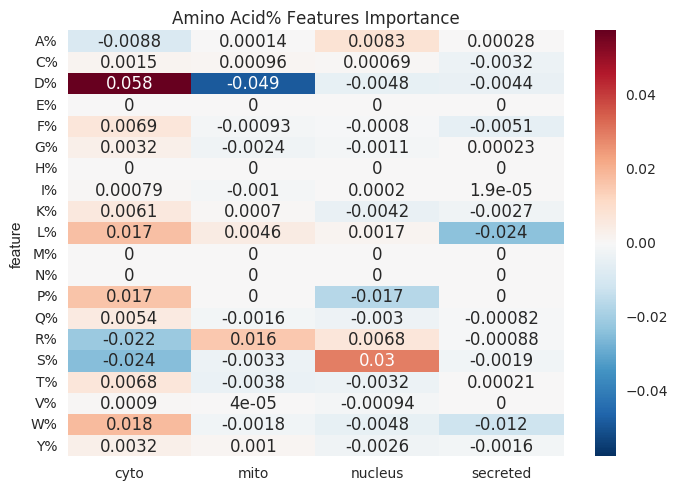

In [689]:
sns.heatmap(amino_pct_feats, annot=True)
plt.title('Amino Acid% Features Importance')
plt.show()

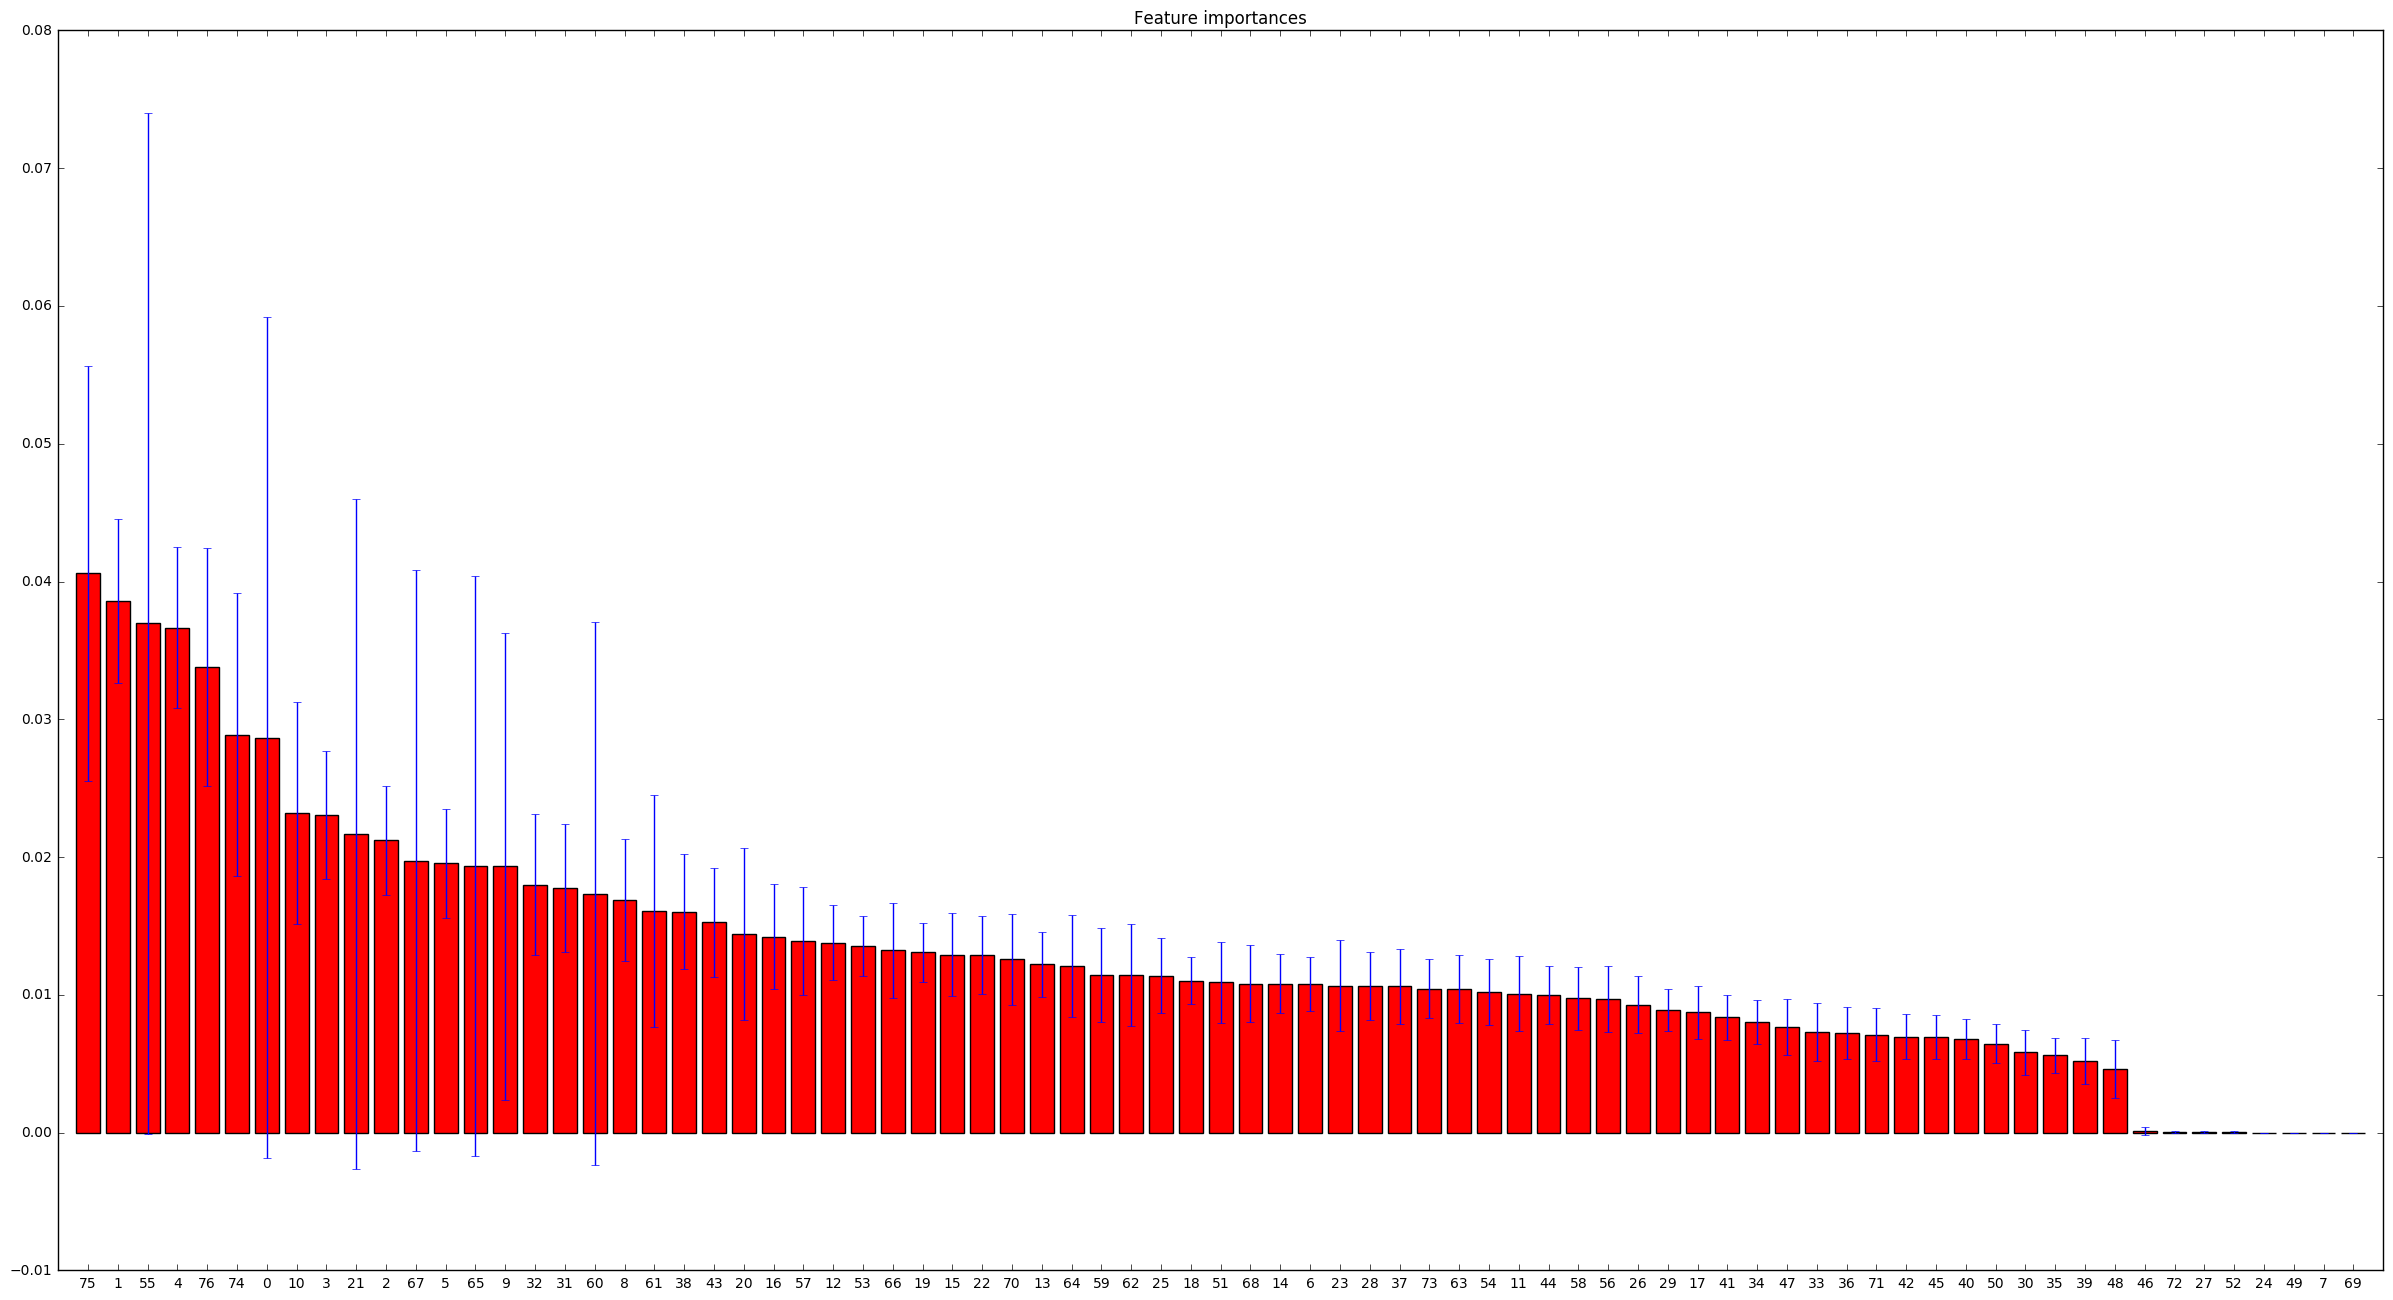

In [164]:
# Plot the feature importances of the forest
plt.figure(figsize=(30,16))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

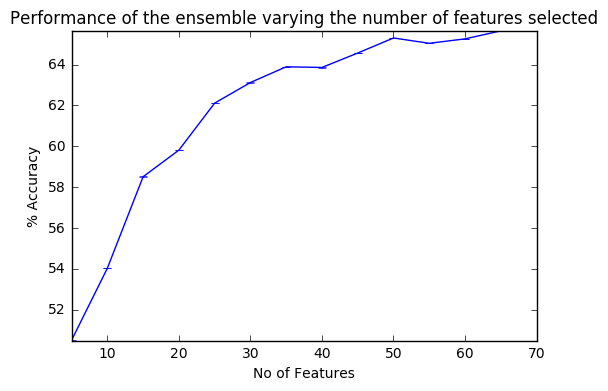

In [136]:
# Feature selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
k_no = np.arange(5,len(X.columns), 5)
acc=[]
score_stds=[]

(np.std(X, axis=0) == 0) 
for k in k_no:
    fs = Pipeline([
      ('feature_selection', SelectKBest(k = k)),
      ('classification', eclf)
    ])
    
    this_scores = cross_val_score(fs, X, y, scoring='accuracy')
    acc.append(this_scores.mean()*100)
    score_stds.append(this_scores.std())

plt.errorbar(k_no, acc, np.array(score_stds))

plt.title(
    'Performance of the ensemble varying the number of features selected')
plt.xlabel('No of Features')
plt.ylabel('% Accuracy')

plt.axis('tight')
plt.show()

In [33]:
# Drop useless features before running the ensemble
for i in useless:
    X = X.drop(X.columns[i], 1)

# Fit ensemble and predict 
y_pred_eclf = eclf.fit(X_train, y_train).predict(X_test)
print('Ensemble Accuracy =', metrics.accuracy_score(y_test, y_pred_eclf))

Ensemble Accuracy = 0.697144922299


Confusion matrix, without normalization


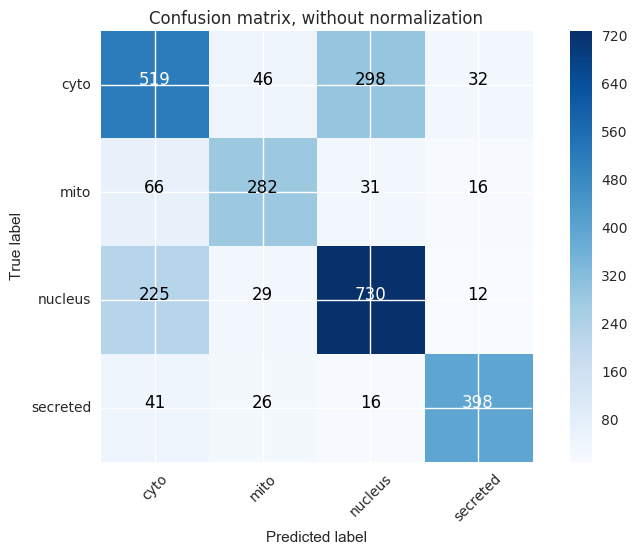

In [697]:
# Confusion matrix
cnf = metrics.confusion_matrix(y_test, y_pred_eclf)

# Plot confusion matrix courtesy of sklearn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure()
plot_confusion_matrix(cnf, classes=labels.unique().tolist(),
                      title='Confusion matrix, without normalization')
plt.show()

In [698]:
# Evaluation Metrics
print(metrics.classification_report(y_test, y_pred_eclf))

             precision    recall  f1-score   support

          0       0.61      0.58      0.59       895
          1       0.74      0.71      0.72       395
          2       0.68      0.73      0.70       996
          3       0.87      0.83      0.85       481

avg / total       0.70      0.70      0.70      2767



In [699]:
# Predict test labels
test_labels = eclf.fit(X_train,y_train).predict(test_df)
test_labels = le.inverse_transform(test_labels)

In [700]:
# Find the confidence scores for predictions
predprobs = eclf.predict_proba(test_df)
confidence_df = pd.DataFrame(predprobs)
confidence = confidence_df.max(axis=1)

In [701]:
# Output
final_output = pd.DataFrame()
final_output['Seq'] = blindidentifiers
final_output['prediction'] = test_labels
final_output['confidence'] = (confidence*100).round(1).astype(str) + '%'
final_output

,Seq,prediction,confidence
0,SEQ677,cyto,39.8%
1,SEQ231,secreted,47.0%
2,SEQ871,secreted,43.0%
3,SEQ388,cyto,43.9%
4,SEQ122,cyto,53.8%
5,SEQ758,nucleus,53.6%
6,SEQ333,cyto,52.3%
7,SEQ937,cyto,60.6%
8,SEQ351,cyto,56.6%
9,SEQ202,cyto,51.7%
